# Transfer Learning Part 1: Feature Extraction

- Transfer learning is leveraging a working model's existing architecture and learned patterns for your own problem.

- **Feature Extraction**: Only the output layer and the dataset change. The hidden layers stay the same.

- **Fine-tuning**: Top layers can get trained on new data.

In [1]:
# Am I unsing a GPU?
!nvidia-smi

Sat Jan 21 02:25:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and Analysing the Data

In [2]:
import zipfile

# Getting the data (10% of 10 food classes from Food101)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip', 'r')
zip_ref.extractall()
zip_ref.close()

--2023-01-21 02:25:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.6MB/s    in 7.9s    

2023-01-21 02:26:08 (20.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10% data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} \
    images in "{dirpath}".')

There are 2 directories and 0     images in "10_food_classes_10_percent".
There are 10 directories and 0     images in "10_food_classes_10_percent/train".
There are 0 directories and 75     images in "10_food_classes_10_percent/train/chicken_wings".
There are 0 directories and 75     images in "10_food_classes_10_percent/train/grilled_salmon".
There are 0 directories and 75     images in "10_food_classes_10_percent/train/chicken_curry".
There are 0 directories and 75     images in "10_food_classes_10_percent/train/steak".
There are 0 directories and 75     images in "10_food_classes_10_percent/train/sushi".
There are 0 directories and 75     images in "10_food_classes_10_percent/train/pizza".
There are 0 directories and 75     images in "10_food_classes_10_percent/train/fried_rice".
There are 0 directories and 75     images in "10_food_classes_10_percent/train/ice_cream".
There are 0 directories and 75     images in "10_food_classes_10_percent/train/ramen".
There are 0 directories and 

## Creating Data Loaders (Preparing the Data)

In [4]:
# Unsing ImageDataGenerator class to load images in batches
# Setup data inputs
from keras.preprocessing.image import ImageDataGenerator

In [5]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training Images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMAGE_SHAPE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

print('Testing Images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


## Setting Up Callbacks

- Tracking experiments with the TensorBoard Callback
- Model checkpoint with the ModelCheckpoint Callback
- Stopping a model from training (avoiding overfitting) with the EarlyStopping Callback

In [6]:
import datetime
import tensorflow as tf

In [7]:
# Creating a TensorBoard Callback
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

## Creating Models using Tensorflow Hub

- Access pretrained models on: https://tfhub.dev/
- https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
- https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [8]:
# Comparing two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [9]:
# Import dependencies
import tensorflow_hub as hub
from keras import layers

In [10]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [11]:
# Creating a function to create e model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a Tensorflow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A Tensorflow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature 
        extractor layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extraction_layer = hub.KerasLayer(model_url,
                                        # Freeze the already learned patterns
                                        trainable=False,
                                        name='feature_extraction_layer',
                                        input_shape=IMAGE_SHAPE+(3,))
    
    # Create a model
    model = tf.keras.Sequential([
        feature_extraction_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])
    return model

### Creating and Testing the ResNet Tensorflow Hub Feature Extraction Model

In [12]:
train_data_10_percent.num_classes

10

In [13]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


- The only trainable params are of the new output layer

In [15]:
# Compile the model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [16]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50v2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20230121-022627
Epoch 1/5
24/24 [==============================] - 29s 733ms/step - loss: 1.9780 - accuracy: 0.3520 - val_loss: 1.2638 - val_accuracy: 0.6036
Epoch 2/5
24/24 [==============================] - 15s 645ms/step - loss: 0.9331 - accuracy: 0.7227 - val_loss: 0.8756 - val_accuracy: 0.7212
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6419 - accuracy: 0.8120 - val_loss: 0.7602 - val_accuracy: 0.7512
Epoch 4/5
24/24 [==============================] - 15s 651ms/step - loss: 0.4977 - accuracy: 0.8667 - val_loss: 0.7131 - val_accuracy: 0.7612
Epoch 5/5
24/24 [==============================] - 15s 645ms/step - loss: 0.3943 - accuracy: 0.9080 - val_loss: 0.6774 - val_accuracy: 0.7748


In [18]:
import matplotlib.pyplot as plt

In [19]:
# Creating a function to plot the loss curves
def plot_loss_curves(history):
    """
    Return separate loss curves for training and validation metrics.

    Args:
        history: Tensorflow History object.

    Returns:
        Plots of training/validation loss and accuracy metrics.
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

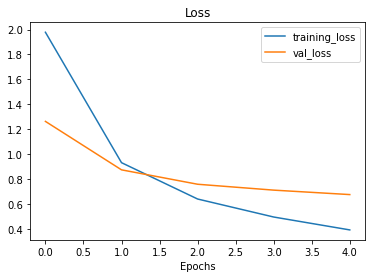

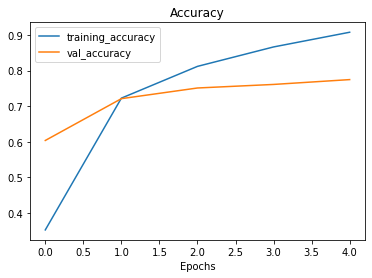

In [20]:
plot_loss_curves(resnet_history)

### Creating and Testing the EfficientNetB0 Tensorflow Hub Feature Extraction Model

In [22]:
# Create EfficientNetB0 feature extraction model
efficientnet_model = create_model(model_url=efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet Model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                    epochs=5,
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_data=test_data,
                                    validation_steps=len(test_data),
                                    callbacks=[create_tensorboard_callback(
                                        dir_name='tensorflow_hub',
                                        experiment_name='efficientnetb0'
                                    )])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230121-030036
Epoch 1/5
24/24 [==============================] - 24s 698ms/step - loss: 1.8214 - accuracy: 0.4467 - val_loss: 1.2814 - val_accuracy: 0.7572
Epoch 2/5
24/24 [==============================] - 14s 612ms/step - loss: 1.0514 - accuracy: 0.7640 - val_loss: 0.8560 - val_accuracy: 0.8264
Epoch 3/5
24/24 [==============================] - 14s 615ms/step - loss: 0.7539 - accuracy: 0.8253 - val_loss: 0.6896 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 15s 643ms/step - loss: 0.6076 - accuracy: 0.8533 - val_loss: 0.6067 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 14s 621ms/step - loss: 0.5144 - accuracy: 0.8853 - val_loss: 0.5527 - val_accuracy: 0.8648


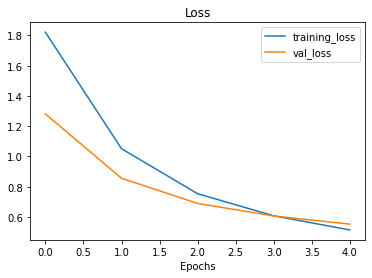

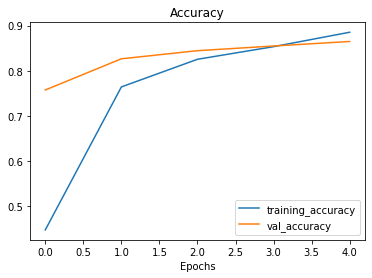

In [23]:
plot_loss_curves(efficientnet_history)

In [24]:
# How many layers does the efficientnetb0 feature extraction have?
len(efficientnet_model.layers[0].weights)

309

## Comparing the Models using TensorBoard

In [26]:
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#     --name "EfficientNetB0 vs. ResNet50V2" \
#     --description "Comparing two different TF Hub feature extraction \
#                     model architectures using 10% of the training data" \
#     --one_shot

https://tensorboard.dev/experiment/NkN7NBW0TBqmXE8wANpksw/#scalars

In [ ]:
# Check out what TensorBoard experiments I have
!tensorboard dev list

In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id <id>